In [2]:
from astropy.io import fits
import sys
import pandas as pd
from astropy.table import unique, Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
from numcosmo_py import Ncm, Nc, sky_match
from numcosmo_py.external.pyssc import pyssc as PySSC
import timeit
Ncm.cfg_init()

from getdist.mcsamples import  MCSamples
from getdist import plots

import getdist
sys.path.insert(0, "/global/homes/l/lettieri/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "/global/homes/l/lettieri/gcr-catalogs")
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")
from GCR import GCRQuery
table_redmapper_halos = fits.open("../forecast/DC2/catalogs/redmapper_halos.fits")[1].data

%matplotlib inline

ModuleNotFoundError: No module named 'gi'

# Cosmological Model

In [ ]:
redmapper_cat = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_redmapper_v0.8.1")

# Taking some important information about the fiducial cosmological model and survey region
redmapper_cosmology = redmapper_cat.cosmology
sky_area = redmapper_cat.sky_area

#cosmological model
cosmo = Nc.HICosmoDEXcdm()
#cosmo.omega_x2omega_k()
#cosmo.param_set_by_name("Omegak",1 - redmapper_cosmology.Ode0 -redmapper_cosmology.Odm0 - redmapper_cosmology.Ob0)
cosmo.param_set_by_name("Omegax", redmapper_cosmology.Ode0)
cosmo.param_set_by_name("H0", redmapper_cosmology.H0.value)
cosmo.param_set_by_name("Omegab", redmapper_cosmology.Ob0)
cosmo.param_set_by_name("Omegac", redmapper_cosmology.Odm0)  # 0.2603

cosmo.param_set_by_name("w", -1.0)  # -1.0

prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA", 2.0)
prim.props.n_SA = redmapper_cosmology.n_s
reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)

#matter power spectrum
tf = Nc.TransferFuncEH()

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
psf.prepare(cosmo)
print(cosmo.sigma8(psf))

old_amplitude = np.exp(prim.props.ln10e10ASA)
prim.props.ln10e10ASA = np.log(
    (redmapper_cosmology.sigma8 / cosmo.sigma8(psf)) ** 2 * old_amplitude
)
print(redmapper_cosmology.sigma8, cosmo.sigma8(psf) , prim.props.ln10e10ASA)



dist = Nc.Distance.new(2.0)
dist.prepare(cosmo)

#parameters to be fitted

cosmo.set_property("Omegac_fit", True)
cosmo.set_property("w_fit", True)
prim.set_property("ln10e10ASA_fit", True)
print(redmapper_cat.sky_area)
print(1 - redmapper_cosmology.Ode0 -redmapper_cosmology.Odm0 - redmapper_cosmology.Ob0)

# Cluster Mass-Richness and photoz model 

In [ ]:
cut = np.log(5)
#cut = -1e50
cluster_m = Nc.ClusterMassAscaso(lnRichness_min = cut ,lnRichness_max = 6.0)
cluster_m.param_set_by_name("mup0", 4.11945317984568)
cluster_m.param_set_by_name("mup1", 1.11236863168254)
cluster_m.param_set_by_name("mup2", 0.299464198653602)
cluster_m.param_set_by_name("sigmap0", 0.471246505057074)
cluster_m.param_set_by_name("sigmap1", -0.0591674971985774)
cluster_m.param_set_by_name("sigmap2", -0.109077938873429)

cluster_m.param_set_by_name("cut", cut)
print(cluster_m.n_limits(cosmo)/np.log(10))
print(cluster_m.p_limits(cosmo, [cut] , [0])/np.log(10))
'''
cluster_m.set_property("mup0_fit", True)
cluster_m.set_property("mup1_fit", True)
cluster_m.set_property("mup2_fit", True)
cluster_m.set_property("sigmap0_fit", True)
cluster_m.set_property("sigmap1_fit", True)
cluster_m.set_property("sigmap2_fit", True)
'''
cluster_z = Nc.ClusterRedshiftNodist(z_min = 0 ,z_max = 1.2)

In [ ]:
lnR = np.linspace(0 ,6 , 1000)
logM = np.linspace(10 , 16 ,1000)
pdf = [cluster_m.p(cosmo , 13 * np.log(10) , 0.3 , [rich]) for rich in lnR]
pdf_mass = [cluster_m.p(cosmo , mass * np.log(10) , 0.3 , [np.log(5)]) for mass in logM]


plt.scatter(lnR , pdf)
plt.show()
plt.scatter(logM , pdf_mass)
plt.show()
print(cluster_m.intp(cosmo , 10* np.log(10) , 0.3))

cdf = [cluster_m.intp(cosmo , mass* np.log(10) , 1.0) for mass in logM]
plt.scatter(logM , cdf)
plt.show()

cluster_photoz = Nc.ClusterPhotozGaussGlobal(pz_min = 0.0 , pz_max = 1.2 , z_bias=0.0 , sigma0 = 0.01)
z = np.linspace(0.0  , 1.2 ,1000)
cdf_z = [cluster_photoz.intp(cosmo , 13* np.log(10) , zi) for zi in z]
plt.scatter(z , cdf_z)
plt.show()

nbins = 1000
lnM_obs = np.linspace(0.0, 6.0 , nbins +1)
cdf_bin = [cluster_m.intp_bin(cosmo , 14* np.log(10) , 0.1 , [lnM_obs[i]] , [lnM_obs[i+1]]) for i in range(nbins)]
lnM_obs_bin = [(lnM_obs[i]+lnM_obs[i+1])/2 for i in range(nbins)]
plt.scatter(lnM_obs_bin , cdf_bin)
plt.show()
print(max(cdf_bin))
print(cdf_bin.index(max(cdf_bin)))
print(lnM_obs_bin[26])
print(lnM_obs[26] , lnM_obs[27])
print(cut)

# Cluster abundance model

In [ ]:
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200.0)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.prepare(cosmo)
hmf.set_area(sky_area * (np.pi / 180) ** 2)
hbias_Tinker = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf, None)
cad.set_area(sky_area * (np.pi / 180) ** 2)

cluster_m_nodist = Nc.ClusterMassNodist(lnM_min = 12.0 *np.log(10) , lnM_max = 16.0 *np.log(10))

cad.prepare(cosmo , cluster_z , cluster_m_nodist)
print(cad.n(cosmo ,cluster_z , cluster_m_nodist))

cad.prepare(cosmo , cluster_z , cluster_m)
print(cad.n(cosmo ,cluster_z , cluster_m))

# Cluster counts likelihood

In [ ]:
rng = Ncm.RNG.seeded_new(None, 13)
mset = Ncm.MSet.new_array([cluster_m, cosmo, cluster_z])
mset.prepare_fparam_map()
dset = Ncm.Dataset.new()

ncdata = Nc.DataClusterNCount.new(cad, "NcClusterRedshiftNodist", "NcClusterMassAscaso")
ncdata.set_init(True)
#cluster_m.set_enable_rejection(False)
ncdata.resample(mset , rng)

dset.append_data(ncdata)

# Likelihood
lh = Ncm.Likelihood.new(dset)

lnM_obs_data = np.array([ncdata.get_lnM_obs().get_col(0).get(i) for i in range(ncdata.get_lnM_obs().get_col(0).len()) if ncdata.get_lnM_true().get(i) >  11* np.log(10)])
lnM_true     = np.array([ncdata.get_lnM_true().get(i) for i in range(ncdata.get_lnM_obs().get_col(0).len())  if ncdata.get_lnM_true().get(i) >  11 * np.log(10)])
z_obs   = [ncdata.get_z_obs().get_col(0).get(i) for i in range(ncdata.get_z_obs().get_col(0).len())]
print(len(lnM_obs_data))
nbins = 100

lnM = np.linspace(12*np.log(10),16*np.log(10))
lnM_bin =[(lnM[i]+lnM[i+1])/2 for i in range(len(lnM)-1)]

lnM_obs = np.linspace(cut- 0.1, 6.0 , nbins +1)
lnM_obs_bin = [(lnM_obs[i] +lnM_obs[i+1])/2 for i in range(len(lnM_obs)-1)]
abundance = [cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnM_obs[i]] , [lnM_obs[i+1]], None, [0] , [1.2] , None)  for i in range(len(lnM_obs)-1)]
plt.hist(lnM_obs_data, bins=lnM_obs)
plt.plot(lnM_obs_bin , abundance)
plt.yscale("log")
plt.xlim(0.0, 6.0)
plt.show()

rich_model = [cluster_m.get_mean_richness(lnM_true[i] , z_obs[i]) for i in range(len(lnM_true))]
rich_model_c = [cluster_m.get_mean(lnM_true[i] , z_obs[i]) for i in range(len(lnM_true))]

plt.scatter(lnM_true / np.log(10),lnM_obs_data  )
plt.scatter(lnM_true/np.log(10) , rich_model)
plt.scatter(lnM_true/np.log(10) , rich_model_c)
plt.ylim(np.log(4) , 6.0)
#plt.xlim(13 , 16)
plt.show()

print(len(lnM_obs_data))

# Fitting correct model

## Fit

In [ ]:
fit = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)

fit.log_info()
fit.run(Ncm.FitRunMsgs.SIMPLE)
#fit.obs_fisher()
#fit.log_covar()

## MC

In [ ]:
Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(2)
fitmc.set_data_file("mc_cut_.fits")

fitmc.start_run()
fitmc.run(2000)
fitmc.end_run()
fitmc.mean_covar()
fit.log_covar()

mcat = Ncm.MSetCatalog.new_from_file_ro("mc_cut.fits", 0)
mcat.log_full_covar()


## MC corner plot

In [ ]:
data_fit_full = (
    pd.DataFrame(fits.open("mc_cut_.fits")[1].data).iloc[:, 1:4].T
)

data_fit_void = np.array(data_fit_full)
data_fit = []
for item in data_fit_void:
    arr = np.array(item)
    data_fit.append(np.asarray(arr.tolist()))

names = [
    "1",
    "2",
    "3"
]
labels = [
    r"\Omega_c",
    r"w",
    r"\ln (10^{10}A_{ASA})",
]
settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples3 = MCSamples(samples=data_fit, names=names, labels=labels, settings=settings)

bf = [redmapper_cosmology.Odm0, -1.0 , prim.props.ln10e10ASA]


samples3.removeBurn(0.3)

# Triangle plot
g2 = plots.get_subplot_plotter()
g2.triangle_plot(
    [samples3],
    filled=True,
    contour_ls="-",
    contour_lws=1,
    fine_bins=1,
    colors=["#b186f1"],
    fontsize=70,
    line_args=[{"lw": 1.2, "ls": "-", "color": "#b186f1"}],
    legend_labels=[
        "Linear",
    ],
)

for i, param in enumerate(names):
    density = samples3.get1DDensity(param)
    x = density.x
    y = density.P
    lower1sigma = density.getLimits(0.68)[0]
    upper1sigma = density.getLimits(0.68)[1]
    lower2sigma = density.getLimits(0.95)[0]
    upper2sigma = density.getLimits(0.95)[1]
    g2.subplots[i, i].fill_between(
        x,
        y,
        where=((x >= lower1sigma) & (x <= upper1sigma)),
        color="blue",
        alpha=0.3,
        label="1σ" if i == 0 else "",
    )

    g2.subplots[i, i].fill_between(
        x,
        y,
        where=((x >= lower2sigma) & (x <= upper2sigma)),
        color="blue",
        alpha=0.1,
        label="2σ" if i == 0 else "",
    )


for i, param1 in enumerate(names):
    for j, param2 in enumerate(names):
        if i == j:
            g2.subplots[i, j].axvline(
                bf[i], color="red", linestyle="--", label="Best Fit"
            )
        elif i > j:
            g2.subplots[i, j].axvline(bf[j], color="red", linestyle="--")
            g2.subplots[i, j].axhline(bf[i], color="red", linestyle="--")


plt.savefig("plots/mc_cut_corner_plot.png")
plt.show()

## MCMC

In [ ]:
'''
nwalkers = 500

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new(fit, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL)
esmcmc.set_nthreads(2)
esmcmc.set_data_file("mcmc_cut.fits")

esmcmc.start_run()
esmcmc.run(400)
esmcmc.end_run()

esmcmc.mean_covar()
fit.log_covar()
'''

# Fitting model with mass-cut

[13.16423695 16.50153931]
[13.16423695 15.58279249]



(process:670533): NUMCOSMO-WARNING **: 09:52:18.303: ncm_integrate_2dim: number of evaluations 10000055 >= maximum number of evaluations 10000000 (nregions 76924, fail 1, result                      0, error   2.52621157545206e-48).


(process:670533): NUMCOSMO-WARNING **: 09:52:22.091: ncm_integrate_2dim: number of evaluations 10000055 >= maximum number of evaluations 10000000 (nregions 76924, fail 1, result                      0, error   2.52621157545206e-48).


(process:670533): NUMCOSMO-WARNING **: 09:52:25.371: ncm_integrate_2dim: number of evaluations 10000055 >= maximum number of evaluations 10000000 (nregions 76924, fail 1, result                      0, error   2.52621157545206e-48).



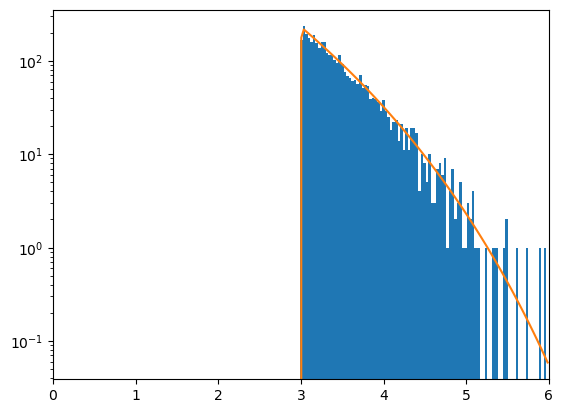

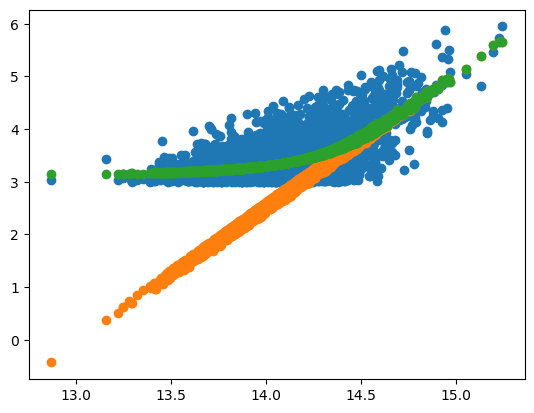

In [7]:
cut = np.log(20)
cluster_m_mass_cut = Nc.ClusterMassAscaso(lnRichness_min = cut ,lnRichness_max = 6.0)
cluster_m_mass_cut.param_set_by_name("mup0", 4.11945317984568)
cluster_m_mass_cut.param_set_by_name("mup1", 1.11236863168254)
cluster_m_mass_cut.param_set_by_name("mup2", 0.299464198653602)
cluster_m_mass_cut.param_set_by_name("sigmap0", 0.471246505057074)
cluster_m_mass_cut.param_set_by_name("sigmap1", -0.0591674971985774)
cluster_m_mass_cut.param_set_by_name("sigmap2", -0.109077938873429)

'''
cluster_m_mass_cut.set_property("mup0_fit", True)
cluster_m_mass_cut.set_property("mup1_fit", True)
cluster_m_mass_cut.set_property("mup2_fit", True)
cluster_m_mass_cut.set_property("sigmap0_fit", True)
cluster_m_mass_cut.set_property("sigmap1_fit", True)
cluster_m_mass_cut.set_property("sigmap2_fit", True)
'''

cluster_m_mass_cut.param_set_by_name("cut", cut)
print(cluster_m_mass_cut.n_limits(cosmo)/np.log(10))
print(cluster_m_mass_cut.p_limits(cosmo, [cut] , [0])/np.log(10))


cad_mass_cut = Nc.ClusterAbundance.new(hmf, None)
cad_mass_cut.set_area(sky_area * (np.pi / 180) ** 2)
cad_mass_cut.prepare(cosmo , cluster_z , cluster_m_mass_cut)

mset_mass_cut = Ncm.MSet.new_array([cluster_m_mass_cut, cosmo, cluster_z])
mset_mass_cut.prepare_fparam_map()

ncdata_mass_cut = Nc.DataClusterNCount.new(cad_mass_cut, "NcClusterRedshiftNodist", "NcClusterMassAscaso")
ncdata_mass_cut.set_init(True)

lnM_obs_data = np.array([ncdata.get_lnM_obs().get_col(0).get(i) for i in range(ncdata.get_lnM_obs().get_col(0).len())])
lnM_true     = np.array([ncdata.get_lnM_true().get(i) for i in range(ncdata.get_lnM_obs().get_col(0).len())])
z_obs   = [ncdata.get_z_obs().get_col(0).get(i) for i in range(ncdata.get_z_obs().get_col(0).len())]

data = {"lnM_true": lnM_true, "lnM_obs":lnM_obs_data , "z":z_obs}
data_table = Table(data)
data_table = data_table[(data_table["lnM_obs"] >= cut)]
rich_model = [cluster_m_mass_cut.get_mean_richness(data_table["lnM_true"][i] , data_table["z"][i]) for i in range(len(data_table))]
rich_model_c = [cluster_m_mass_cut.get_mean(data_table["lnM_true"][i] , data_table["z"][i]) for i in range(len(data_table))]



lnM_obs = np.linspace(cut - 0.1, 6.0 , nbins +1)
lnM_obs_bin = [(lnM_obs[i] +lnM_obs[i+1])/2 for i in range(len(lnM_obs)-1)]
abundance_mass_cut = [cad_mass_cut.intp_bin_d2n(cosmo, cluster_z, cluster_m_mass_cut, [lnM_obs[i]] , [lnM_obs[i+1]], None, [0] , [1.2] , None)  for i in range(len(lnM_obs)-1)]
plt.hist(data_table['lnM_obs'], bins=lnM_obs)
plt.plot(lnM_obs_bin , abundance_mass_cut)
plt.yscale("log")
plt.xlim(0.0, 6.0)
plt.show()


plt.scatter(data_table['lnM_true']/np.log(10),data_table['lnM_obs'])
plt.scatter(data_table['lnM_true']/np.log(10) , rich_model)
plt.scatter(data_table['lnM_true']/np.log(10) , rich_model_c)
plt.show()

lnM_true_vec   = Ncm.Vector.new_array(data_table['lnM_true'])
z_true_vec     = Ncm.Vector.new_array(data_table['z'])
lnM_obs_matrix = Ncm.Matrix.new_array(data_table['lnM_obs'] , 1)
z_obs_matrix   = Ncm.Matrix.new_array(data_table['z'] , 1)

ncdata_mass_cut.set_lnM_true(lnM_true_vec)
ncdata_mass_cut.set_z_true(z_true_vec)

ncdata_mass_cut.set_lnM_obs(lnM_obs_matrix)
ncdata_mass_cut.set_z_obs(z_obs_matrix)

dset_mass_cut = Ncm.Dataset.new()
dset_mass_cut.append_data(ncdata_mass_cut)
lh_mass_cut = Ncm.Likelihood.new(dset_mass_cut)

## Fit

In [8]:
fit_mass_cut = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh_mass_cut, mset_mass_cut, Ncm.FitGradType.NUMDIFF_CENTRAL
)

fit_mass_cut.log_info()
#fit_mass_cut.run(Ncm.FitRunMsgs.SIMPLE)

#fit_mass_cut.log_info()

#----------------------------------------------------------------------------------
# Data used:
#   - Cluster abundance unbinned
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  71                  [FIXED]
#   -     Omegac[01]:  0.22                [FREE]
#   -     Omegax[02]:  0.7352              [FIXED]
#   -    Tgamma0[03]:  2.7245              [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.046               [FIXED]
#   -     Omegab[06]:  0.0448              [FIXED]
#   -          w[07]: -1                   [FREE]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra
#------------------------------------------------------------------

## MC

In [9]:
Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

fitmc_mass_cut = Ncm.FitMC.new(fit_mass_cut, Ncm.FitMCResampleType.FROM_MODEL , Ncm.FitRunMsgs.SIMPLE)
fitmc_mass_cut.set_nthreads(2)
fitmc_mass_cut.set_data_file("mc_mass_cut.fits")

fitmc_mass_cut.start_run()
fitmc_mass_cut.run(2000)
fitmc_mass_cut.end_run()
fitmc_mass_cut.mean_covar()
fit_mass_cut.log_covar()

mcat_mass_cut = Ncm.MSetCatalog.new_from_file_ro("mc_mass_cut.fits", 0)
mcat_mass_cut.log_full_covar()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      2
#----------------------------------------------------------------------------------
# NcmFitMC: Skipping 2000 realizations, will start at 2001-th realization.
#----------------------------------------------------------------------------------
# NcmFitMC: Nothing to do, current Monte Carlo run is 2000
#----------------------------------------------------------------------------------
# NcmMSet parameters covariance matrix
#                                                      ----------------------------------------------
#     Omegac[03000:01] =  0.2202      +/-  0.01553     |  1           |  0.9279      | -0.09677     |
#          w[03000:07] = -1.004       +/-  0.1318      |  0.9279      |  1           |  0.2581      |
# ln10e10ASA[05000:00] =  3.07        +/-  0.06749     | -0.09677     |  0.2581      |  1           |
#           

Removed no burn in


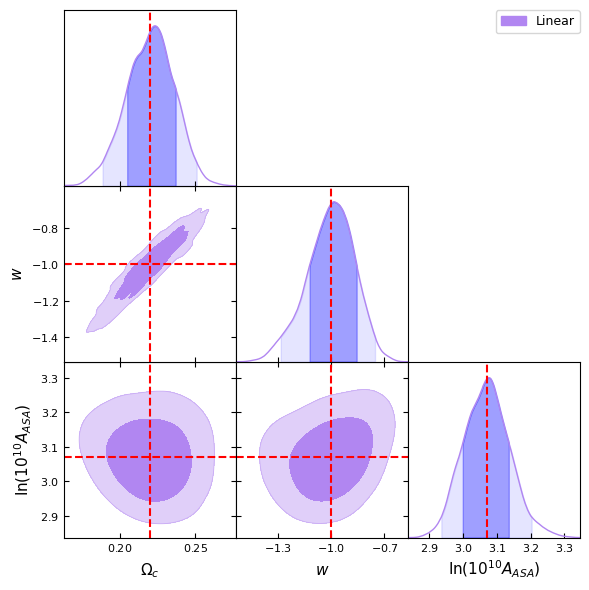

In [10]:
data_fit_full = (
    pd.DataFrame(fits.open("mc_mass_cut.fits")[1].data).iloc[:, 1:4].T
)

data_fit_void = np.array(data_fit_full)
data_fit = []
for item in data_fit_void:
    arr = np.array(item)
    data_fit.append(np.asarray(arr.tolist()))

names = [
    "1",
    "2",
    "3"
]
labels = [
    r"\Omega_c",
    r"w",
    r"\ln (10^{10}A_{ASA})",
]
settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples3 = MCSamples(samples=data_fit, names=names, labels=labels, settings=settings)

bf = [redmapper_cosmology.Odm0, -1.0 , prim.props.ln10e10ASA]


samples3.removeBurn(0.3)

# Triangle plot
g2 = plots.get_subplot_plotter()
g2.triangle_plot(
    [samples3],
    filled=True,
    contour_ls="-",
    contour_lws=1,
    fine_bins=1,
    colors=["#b186f1"],
    fontsize=70,
    line_args=[{"lw": 1.2, "ls": "-", "color": "#b186f1"}],
    legend_labels=[
        "Linear",
    ],
)

for i, param in enumerate(names):
    density = samples3.get1DDensity(param)
    x = density.x
    y = density.P
    lower1sigma = density.getLimits(0.68)[0]
    upper1sigma = density.getLimits(0.68)[1]
    lower2sigma = density.getLimits(0.95)[0]
    upper2sigma = density.getLimits(0.95)[1]
    g2.subplots[i, i].fill_between(
        x,
        y,
        where=((x >= lower1sigma) & (x <= upper1sigma)),
        color="blue",
        alpha=0.3,
        label="1σ" if i == 0 else "",
    )

    g2.subplots[i, i].fill_between(
        x,
        y,
        where=((x >= lower2sigma) & (x <= upper2sigma)),
        color="blue",
        alpha=0.1,
        label="2σ" if i == 0 else "",
    )


for i, param1 in enumerate(names):
    for j, param2 in enumerate(names):
        if i == j:
            g2.subplots[i, j].axvline(
                bf[i], color="red", linestyle="--", label="Best Fit"
            )
        elif i > j:
            g2.subplots[i, j].axvline(bf[j], color="red", linestyle="--")
            g2.subplots[i, j].axhline(bf[i], color="red", linestyle="--")


plt.savefig("plots/mc_mass_cut_corner_plot.png")
plt.show()

## MCMC

In [ ]:
nwalkers = 500

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc_mass_cut = Ncm.FitESMCMC.new(fit_mass_cut, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL)
esmcmc_mass_cut.set_nthreads(2)
esmcmc_mass_cut.set_data_file("mcmc_mass_cut.fits")

esmcmc_mass_cut.start_run()
esmcmc_mass_cut.run(400)
esmcmc_mass_cut.end_run()

esmcmc_mass_cut.mean_covar()
fit_mass_cut.log_covar()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      2
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensemble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0500.
#   Number of threads: 0002.
#   Using MPI:         no - use MPI enabled but no slaves available.
#----------------------------------------------------------------------------------
# Data used:
#   - Cluster abundance unbinned
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Model set:
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  71                  [FIXED]
#   -     Omegac[01]:  0.21756273

# MC corner comparison

Removed no burn in
Removed no burn in


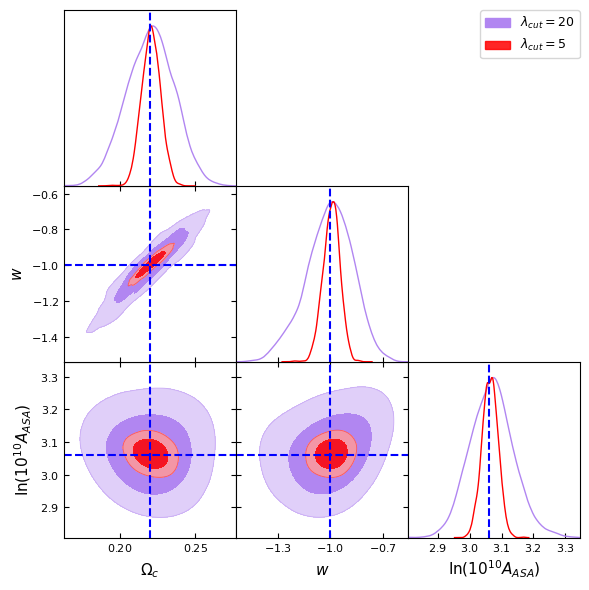

In [6]:
data_fit_full = (
    pd.DataFrame(fits.open("mc_cut_.fits")[1].data).iloc[:, 1:4].T
)

data_fit_full_mass = (
    pd.DataFrame(fits.open("mc_mass_cut.fits")[1].data).iloc[:, 1:4].T
)

data_fit_void = np.array(data_fit_full)
data_fit_void_2 = np.array(data_fit_full_mass)
data_fit = []
for item in data_fit_void:
    arr = np.array(item)
    data_fit.append(np.asarray(arr.tolist()))

data_fit_2 = []
for item in data_fit_void_2:
    arr = np.array(item)
    data_fit_2.append(np.asarray(arr.tolist()))

names = [
    "1",
    "2",
    "3"
]
labels = [
    r"\Omega_c",
    r"w",
    r"\ln (10^{10}A_{ASA})",
]
settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples3 = MCSamples(samples=data_fit, names=names, labels=labels, settings=settings)
samples_mass = MCSamples(samples=data_fit_2, names=names, labels=labels, settings=settings)

bf = [redmapper_cosmology.Odm0, -1.0 , prim.props.ln10e10ASA]


samples3.removeBurn(0.3)

# Triangle plot
g2 = plots.get_subplot_plotter()
g2.triangle_plot(
    [samples_mass,samples3],
    filled=True,
    contour_ls="-",
    contour_lws=1,
    fine_bins=1,
    colors=["#b186f1" , "red"],
    fontsize=70,
    line_args=[{"lw": 1.2, "ls": "-", "color": "#b186f1"}],
    legend_labels=[
        r"$\lambda_{cut} =20$",r"$\lambda_{cut} =5$"
    ],
)


for i, param1 in enumerate(names):
    for j, param2 in enumerate(names):
        if i == j:
            g2.subplots[i, j].axvline(
                bf[i], color="blue" ,linestyle="--", label="Best Fit"
            )
        elif i > j:
            g2.subplots[i, j].axvline(bf[j], color="blue", linestyle="--")
            g2.subplots[i, j].axhline(bf[i], color="blue", linestyle="--")


plt.savefig("plots/mc_comparison_corner_plot.png")
plt.show()

# Fitting uncorrect model

## Fit

In [ ]:
cluster_m.param_set_by_name("cut", -1e15)
fit = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)

fit.log_info()
fit.run(Ncm.FitRunMsgs.SIMPLE)

fit.log_info()

## MC

In [ ]:
cluster_m.param_set_by_name("cut", -1e15)

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.BOOTSTRAP_NOMIX , Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(2)
fitmc.set_data_file("mc_no_cut.fits")

fitmc.start_run()
fitmc.run(1000)
fitmc.end_run()
fitmc.mean_covar()
fit.log_covar()

mcat = Ncm.MSetCatalog.new_from_file_ro("mc_no_cut.fits", 0)
mcat.log_full_covar()

## MCMC

In [ ]:
cluster_m.param_set_by_name("cut", -1e15)
nwalkers = 500

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new(fit, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL)
esmcmc.set_nthreads(2)
esmcmc.set_data_file("mcmc_no_cut.fits")

esmcmc.start_run()
esmcmc.run(1200)
esmcmc.end_run()

esmcmc.mean_covar()
fit.log_covar()